In [1]:
from typing import Callable
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from matplotlib.animation import FuncAnimation
from functools import partial
import time
import os
from typing import Tuple
from copy import deepcopy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

LENGTH = 1. # Domain size in x axis. Always starts at 0
TOTAL_TIME = 1. # Domain size in t axis. Always starts at 0
N_POINTS = 35 # Number of in single asxis
N_POINTS_PLOT = 150 # Number of points in single axis used in plotting
WEIGHT_RESIDUAL = 1.0 # Weight of residual part of loss function
WEIGHT_INITIAL = 1.0 # Weight of initial part of loss function
WEIGHT_BOUNDARY = 1.0 # Weight of boundary part of loss function
LAYERS = 4
NEURONS_PER_LAYER = 160
EPOCHS = 20_000
LEARNING_RATE = 0.002

x_domain = [0.0, LENGTH]
y_domain = [0.0, LENGTH]
t_domain = [0.0, TOTAL_TIME]

def initial_condition(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    d = torch.sqrt((x-0.6)**2 + (y-0.6)**2)
    res = -d**2 - 4*d + 0.4
    res = res * (res > 0)
    return res


class PINN(nn.Module):
    """
    Simple neural network accepting two features as input and returning a single output
    In the context of PINNs, the neural network is used as universal function approximator
    to approximate the solution of the differential equation
    """
    def __init__(self, num_hidden: int, dim_hidden: int, act=nn.Tanh()):
        super().__init__()
        self.layer_in = nn.Linear(3, dim_hidden)
        self.layer_out = nn.Linear(dim_hidden, 1)
        num_middle = num_hidden - 1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden, dim_hidden) for _ in range(num_middle)] #nn.utils.weight_norm(nn.Linear)
        )
        self.act = act

    def forward(self, x, y, t):
        x_stack = torch.cat([x, y, t], dim=1)
        out = self.act(self.layer_in(x_stack))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        logits = self.layer_out(out)
        return logits

    def device(self):
        return next(self.parameters()).device


def f(pinn: PINN, x: torch.Tensor, y: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """Compute the value of the approximate solution from the NN model"""
    return pinn(x, y, t)


def df(output: torch.Tensor, input: torch.Tensor, order: int = 1) -> torch.Tensor:
    """Compute neural network derivative with respect to input features using PyTorch autograd engine"""
    df_value = output
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            input,
            grad_outputs=torch.ones_like(input),
            create_graph=True,
            retain_graph=True,
        )[0]
    return df_value


def dfdt(pinn: PINN, x: torch.Tensor, y: torch.Tensor, t: torch.Tensor, order: int = 1):
    f_value = f(pinn, x, y, t)
    return df(f_value, t, order=order)


def dfdx(pinn: PINN, x: torch.Tensor, y: torch.Tensor, t: torch.Tensor, order: int = 1):
    f_value = f(pinn, x, y, t)
    return df(f_value, x, order=order)


def dfdy(pinn: PINN, x: torch.Tensor, y: torch.Tensor, t: torch.Tensor, order: int = 1):
    f_value = f(pinn, x, y, t)
    return df(f_value, y, order=order)


def get_boundary_points(x_domain, y_domain, t_domain, n_points, device = torch.device("cpu"), requires_grad=True):
    """
         .+------+
       .' |    .'|
      +---+--+'  |
      |   |  |   |
    y |  ,+--+---+
      |.'    | .' t
      +------+'
          x
    """
    x_linspace = torch.linspace(x_domain[0], x_domain[1], n_points)
    y_linspace = torch.linspace(y_domain[0], y_domain[1], n_points)
    t_linspace = torch.linspace(t_domain[0], t_domain[1], n_points)

    x_grid, t_grid = torch.meshgrid( x_linspace, t_linspace, indexing="ij")
    y_grid, _ = torch.meshgrid( y_linspace, t_linspace, indexing="ij")

    x_grid = x_grid.reshape(-1, 1).to(device)
    x_grid.requires_grad = requires_grad
    y_grid = y_grid.reshape(-1, 1).to(device)
    y_grid.requires_grad = requires_grad
    t_grid = t_grid.reshape(-1, 1).to(device)
    t_grid.requires_grad = requires_grad

    x0 = torch.full_like(t_grid, x_domain[0], requires_grad=requires_grad)
    x1 = torch.full_like(t_grid, x_domain[1], requires_grad=requires_grad)
    y0 = torch.full_like(t_grid, y_domain[0], requires_grad=requires_grad)
    y1 = torch.full_like(t_grid, y_domain[1], requires_grad=requires_grad)

    down = (x_grid, y0, t_grid)
    up = (x_grid, y1, t_grid)
    left = (x0, y_grid, t_grid)
    right = (x1, y_grid, t_grid)

    return down, up, left, right


def get_initial_points(x_domain, y_domain, t_domain, n_points, device = torch.device("cpu"), requires_grad=True):
    x_linspace = torch.linspace(x_domain[0], x_domain[1], n_points)
    y_linspace = torch.linspace(y_domain[0], y_domain[1], n_points)
    x_grid, y_grid = torch.meshgrid( x_linspace, y_linspace, indexing="ij")
    x_grid = x_grid.reshape(-1, 1).to(device)
    x_grid.requires_grad = requires_grad
    y_grid = y_grid.reshape(-1, 1).to(device)
    y_grid.requires_grad = requires_grad
    t0 = torch.full_like(x_grid, t_domain[0], requires_grad=requires_grad)
    return (x_grid, y_grid, t0)


def get_interior_points(x_domain, y_domain, t_domain, n_points, device = torch.device("cpu"), requires_grad=True):
    x_raw = torch.linspace(x_domain[0], x_domain[1], steps=n_points, requires_grad=requires_grad)
    y_raw = torch.linspace(y_domain[0], y_domain[1], steps=n_points, requires_grad=requires_grad)
    t_raw = torch.linspace(t_domain[0], t_domain[1], steps=n_points, requires_grad=requires_grad)
    grids = torch.meshgrid(x_raw, y_raw, t_raw, indexing="ij")

    x = grids[0].reshape(-1, 1).to(device)
    y = grids[1].reshape(-1, 1).to(device)
    t = grids[2].reshape(-1, 1).to(device)
    return x, y, t


class Loss:
    def __init__(
        self,
        x_domain: Tuple[float, float],
        y_domain: Tuple[float, float],
        t_domain: Tuple[float, float],
        n_points: int,
        initial_condition: Callable,
        weight_r: float = 1.0,
        weight_b: float = 1.0,
        weight_i: float = 1.0,
        verbose: bool = False,
    ):
        self.x_domain = x_domain
        self.y_domain = y_domain
        self.t_domain = t_domain
        self.n_points = n_points
        self.initial_condition = initial_condition
        self.weight_r = weight_r
        self.weight_b = weight_b
        self.weight_i = weight_i

    def residual_loss(self, pinn: PINN):
        x, y, t = get_interior_points(self.x_domain, self.y_domain, self.t_domain, self.n_points, pinn.device())
        rho = 0.025
        def D_fun(x, y) -> torch.Tensor:
            res = torch.zeros(x.shape, dtype=x.dtype, device=pinn.device())
            dist = (x-0.5)**2 + (y-0.5)**2
            res[dist < 0.25] = 0.13
            res[dist < 0.02] = 0.013
            return res
        D = D_fun(x, y)
        u = f(pinn, x, y, t)
        loss = dfdt(pinn, x, y, t) - D * dfdx(pinn, x, y, t, order=2) - D * dfdy(pinn, x, y, t, order=2) - rho * u * (1 - u)
        return loss.pow(2).mean()

    def initial_loss(self, pinn: PINN):
        x, y, t = get_initial_points(self.x_domain, self.y_domain, self.t_domain, self.n_points, pinn.device())
        pinn_init = self.initial_condition(x, y)
        loss = f(pinn, x, y, t) - pinn_init
        return loss.pow(2).mean()

    def boundary_loss(self, pinn: PINN):
        down, up, left, right = get_boundary_points(self.x_domain, self.y_domain, self.t_domain, self.n_points, pinn.device())
        x_down, y_down, t_down = down
        x_up, y_up, t_up = up
        x_left, y_left, t_left = left
        x_right, y_right, t_right = right
        loss_down = dfdy( pinn, x_down, y_down, t_down )
        loss_up = dfdy( pinn, x_up, y_up, t_up )
        loss_left = dfdx( pinn, x_left, y_left, t_left )
        loss_right = dfdx( pinn, x_right, y_right, t_right )

        return loss_down.pow(2).mean() + \
            loss_up.pow(2).mean() + \
            loss_left.pow(2).mean() + \
            loss_right.pow(2).mean()

    def verbose(self, pinn: PINN):
        """
        Returns all parts of the loss function
        Not used during training! Only for checking the results later.
        """
        residual_loss = self.residual_loss(pinn)
        initial_loss = self.initial_loss(pinn)
        boundary_loss = self.boundary_loss(pinn)

        final_loss = \
            self.weight_r * residual_loss + \
            self.weight_i * initial_loss + \
            self.weight_b * boundary_loss

        return final_loss, residual_loss, initial_loss, boundary_loss

    def __call__(self, pinn: PINN):
        """
        Allows you to use instance of this class as if it was a function:
        ```
        >>> loss = Loss(*some_args)
        >>> calculated_loss = loss(pinn)
        ```
        """
        return self.verbose(pinn)[0]


def train_model(
        nn_approximator: PINN,
        loss_fn: Callable,
        learning_rate: int = 0.01,
        max_epochs: int = 1_000
    ) -> PINN:
        optimizer = torch.optim.Adam(nn_approximator.parameters(), lr=learning_rate)
        loss_values = []
        best_approximator = deepcopy(nn_approximator)
        best_loss = loss_fn(nn_approximator).item()
        for epoch in range(max_epochs):
            try:
                epoch_start_time = time.time()
                loss: torch.Tensor = loss_fn(nn_approximator)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss = loss.item()
                loss_values.append(total_loss)
                if total_loss < best_loss:
                    best_approximator = deepcopy(nn_approximator)
                    best_loss = total_loss
                if (epoch + 1) % 1000 == 0:
                    print(f"Epoch: {epoch + 1}\tLoss: {float(loss):>7f}\tTime: {time.time() - epoch_start_time}s")
            except KeyboardInterrupt:
                break
        return best_approximator, np.array(loss_values)


def plot_solution(pinn: PINN, x: torch.Tensor, t: torch.Tensor, figsize=(8, 6), dpi=100):
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    x_raw = torch.unique(x).reshape(-1, 1)
    t_raw = torch.unique(t)

    def animate(i):
        if not i % 10 == 0:
            t_partial = torch.ones_like(x_raw) * t_raw[i]
            f_final = f(pinn, x_raw, t_partial)
            ax.clear()
            ax.plot(
                x_raw.detach().numpy(), f_final.detach().numpy(), label=f"Time {float(t[i])}"
            )
            ax.set_ylim(-1, 1)
            ax.legend()

    n_frames = t_raw.shape[0]
    return FuncAnimation(fig, animate, frames=n_frames, interval=100, repeat=False)


def plot_color(z: torch.Tensor, x: torch.Tensor, y: torch.Tensor, n_points_x, n_points_t, title, figsize=(8, 6), dpi=100, cmap="viridis"):
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    z_raw = z.detach().cpu().numpy()
    x_raw = x.detach().cpu().numpy()
    y_raw = y.detach().cpu().numpy()
    X = x_raw.reshape(n_points_x, n_points_t)
    Y = y_raw.reshape(n_points_x, n_points_t)
    Z = z_raw.reshape(n_points_x, n_points_t)
    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    c = ax.pcolormesh(X, Y, Z, cmap=cmap)
    fig.colorbar(c, ax=ax)

    return fig


def plot_3D(z: torch.Tensor, x: torch.Tensor, y: torch.Tensor, n_points_x, n_points_t, title, figsize=(8, 6), dpi=100, limit=0.2):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(projection='3d')
    z_raw = z.detach().cpu().numpy()
    x_raw = x.detach().cpu().numpy()
    y_raw = y.detach().cpu().numpy()
    X = x_raw.reshape(n_points_x, n_points_t)
    Y = y_raw.reshape(n_points_x, n_points_t)
    Z = z_raw.reshape(n_points_x, n_points_t)
    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.axes.set_zlim3d(bottom=-limit, top=limit)
    c = ax.plot_surface(X, Y, Z)
    return fig


def running_average(y, window=100):
    cumsum = np.cumsum(np.insert(y, 0, 0))
    return (cumsum[window:] - cumsum[:-window]) / float(window)


path = './tmp'
if not os.path.exists(path):
    os.makedirs(path)


x, y, _ = get_initial_points(x_domain, y_domain, t_domain, N_POINTS_PLOT, requires_grad=False)
z = initial_condition(x, y)
fig = plot_color(z, x, y, N_POINTS_PLOT, N_POINTS_PLOT, "Initial condition - exact")
plt.savefig("./tmp/initial_condition.png", transparent = True)
plt.close()


pinn = PINN(LAYERS, NEURONS_PER_LAYER, act=nn.Tanh()).to(device)

# train the PINN
loss_fn = Loss(
    x_domain,
    y_domain,
    t_domain,
    N_POINTS,
    initial_condition,
    WEIGHT_RESIDUAL,
    WEIGHT_INITIAL,
    WEIGHT_BOUNDARY
)

pinn_trained, loss_values = train_model(
    pinn, loss_fn=loss_fn, learning_rate=LEARNING_RATE, max_epochs=EPOCHS)


cuda
Epoch: 1000	Loss: 0.000748	Time: 0.06362676620483398s
Epoch: 2000	Loss: 0.000746	Time: 0.06143069267272949s
Epoch: 3000	Loss: 0.000745	Time: 0.061949729919433594s
Epoch: 4000	Loss: 0.000743	Time: 0.06161904335021973s
Epoch: 5000	Loss: 0.000740	Time: 0.06276345252990723s
Epoch: 6000	Loss: 0.000739	Time: 0.061760902404785156s
Epoch: 7000	Loss: 0.000736	Time: 0.06274104118347168s
Epoch: 8000	Loss: 0.000729	Time: 0.06176567077636719s
Epoch: 9000	Loss: 0.000724	Time: 0.06378173828125s
Epoch: 10000	Loss: 0.000749	Time: 0.06220674514770508s
Epoch: 11000	Loss: 0.000747	Time: 0.06329989433288574s
Epoch: 12000	Loss: 0.000743	Time: 0.06246066093444824s
Epoch: 13000	Loss: 0.000734	Time: 0.06094193458557129s
Epoch: 14000	Loss: 0.000728	Time: 0.06238722801208496s
Epoch: 15000	Loss: 0.000718	Time: 0.06092476844787598s
Epoch: 16000	Loss: 0.000752	Time: 0.0609285831451416s
Epoch: 17000	Loss: 0.000631	Time: 0.060286521911621094s
Epoch: 18000	Loss: 0.000528	Time: 0.06201672554016113s
Epoch: 19000	Lo

In [2]:
pinn_trained = pinn_trained.cpu()
losses = loss_fn.verbose(pinn_trained)
print(f'Total loss: \t{losses[0]:.5f} ({losses[0]:.3E})')
print(f'Interior loss: \t{losses[1]:.5f} ({losses[1]:.3E})')
print(f'Initial loss: \t{losses[2]:.5f} ({losses[2]:.3E})')
print(f'Bondary loss: \t{losses[3]:.5f} ({losses[3]:.3E})')
torch.save(pinn_trained.state_dict(), "./tmp/model")

Total loss: 	0.00028 (2.782E-04)
Interior loss: 	0.00009 (9.131E-05)
Initial loss: 	0.00018 (1.829E-04)
Bondary loss: 	0.00000 (3.974E-06)


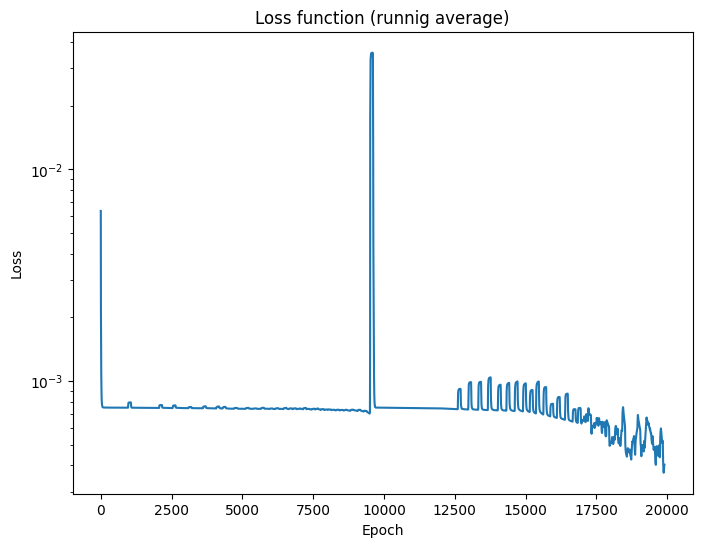

In [3]:
average_loss = running_average(loss_values, window=100)
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
ax.set_title("Loss function (runnig average)")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.plot(average_loss)
ax.set_yscale('log')
plt.savefig("./tmp/total_loss.png", transparent = True)

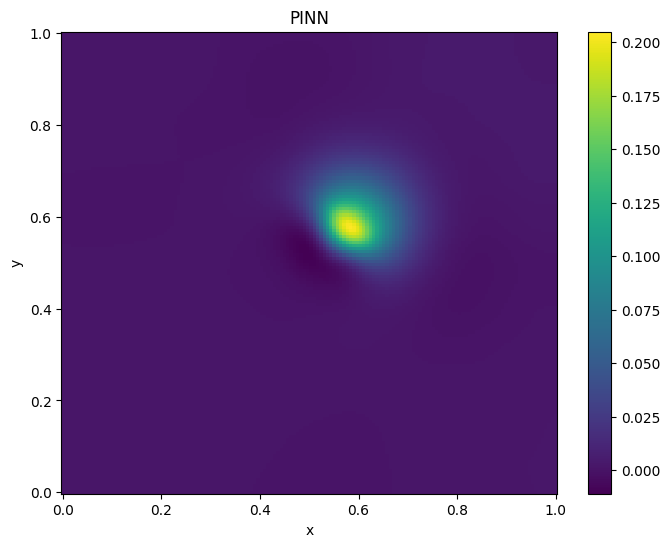

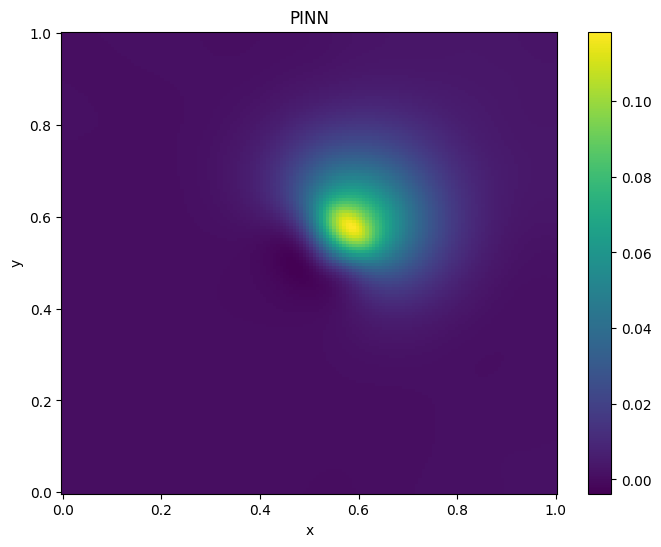

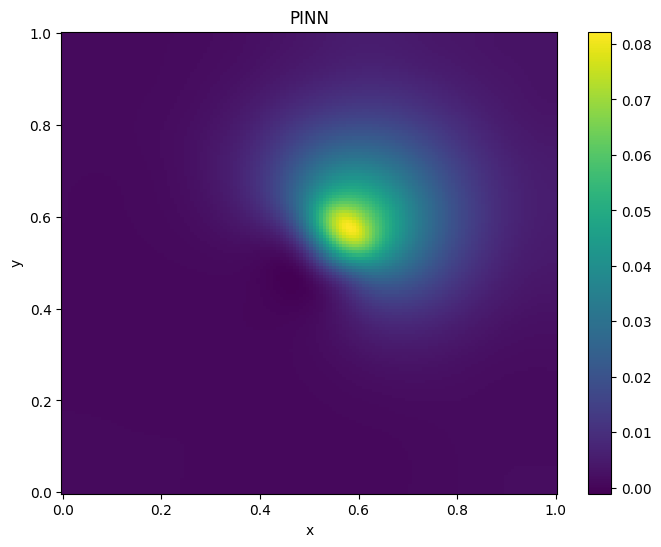

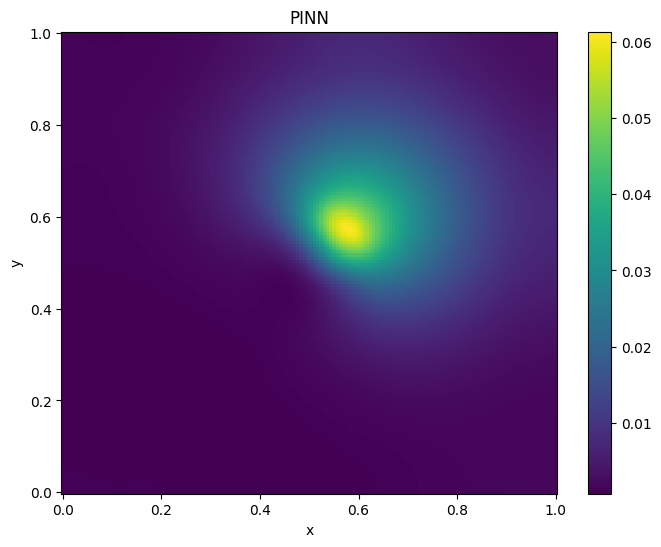

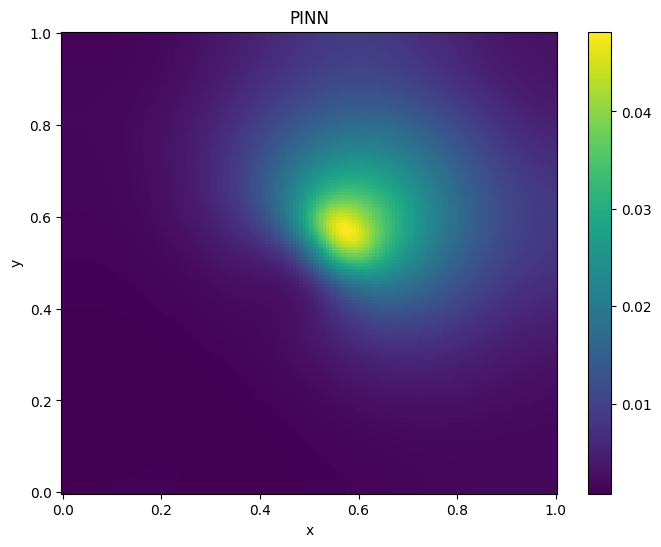

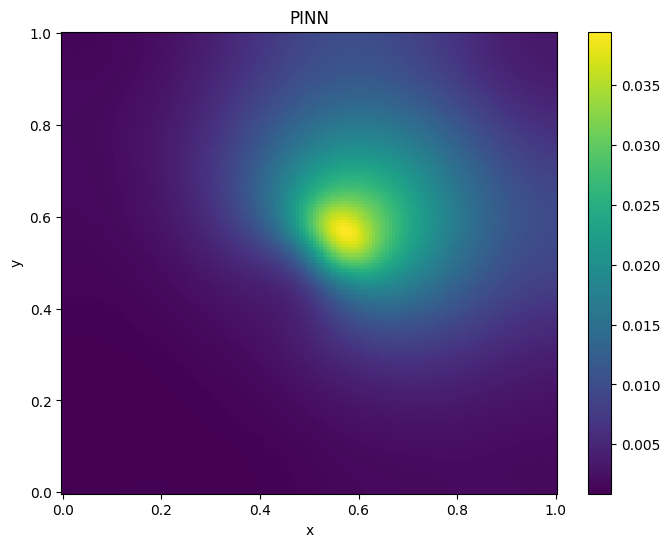

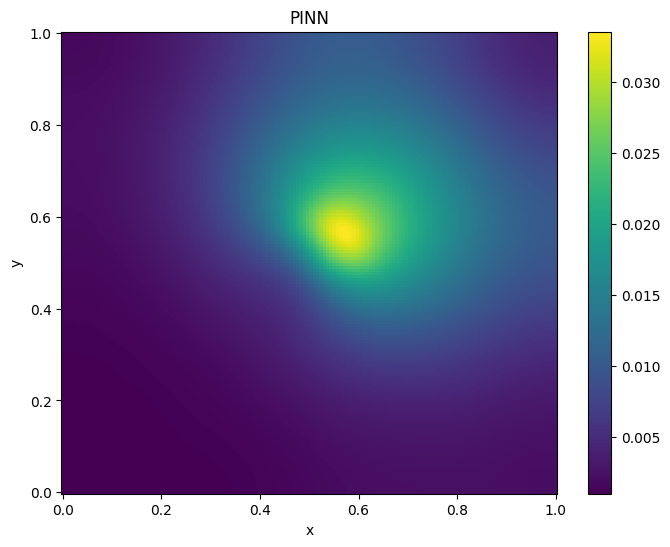

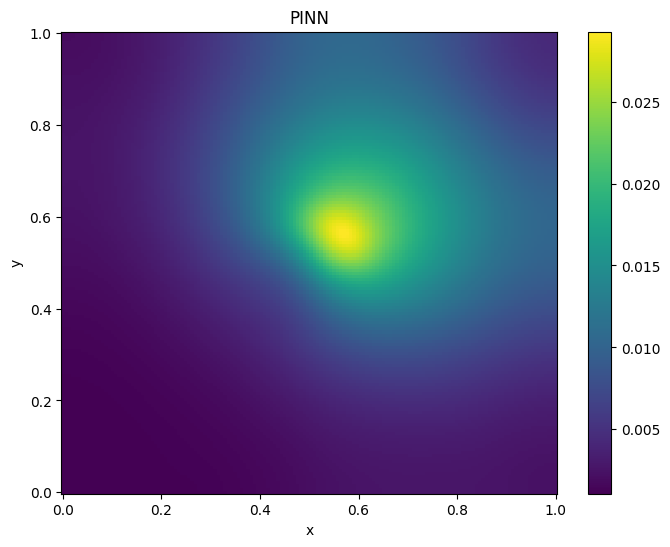

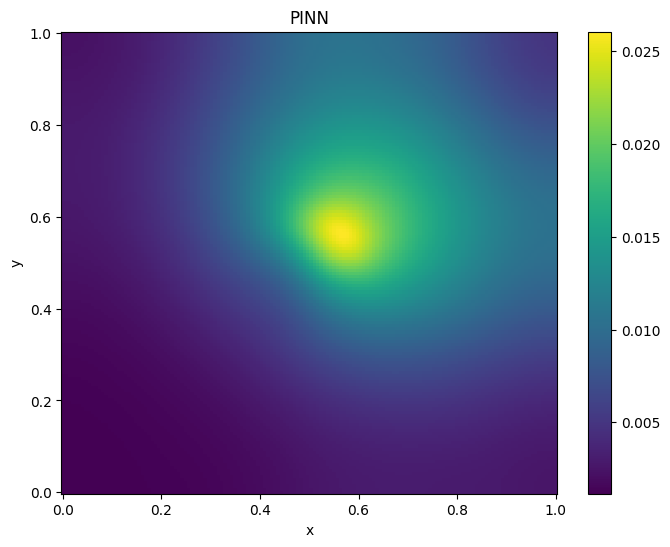

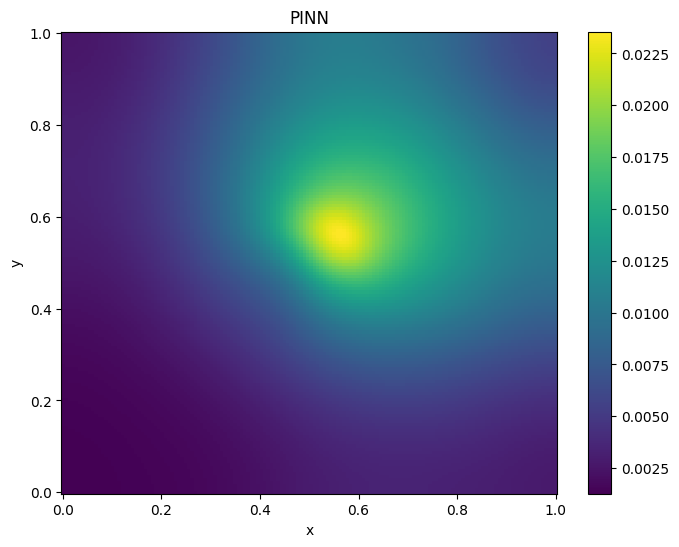

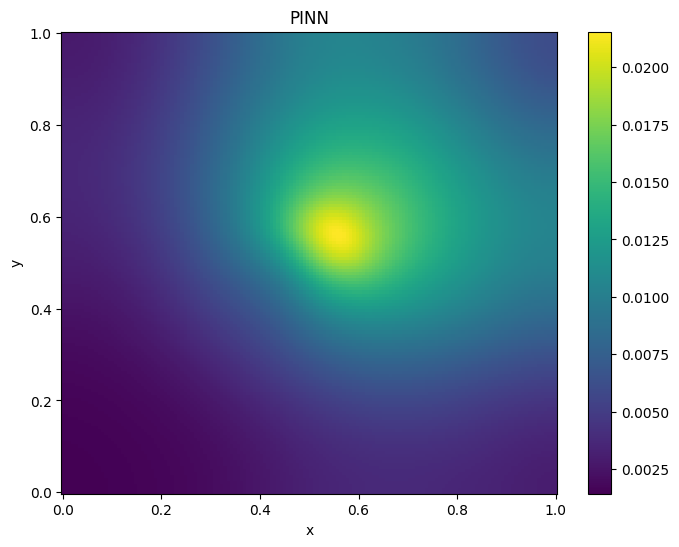

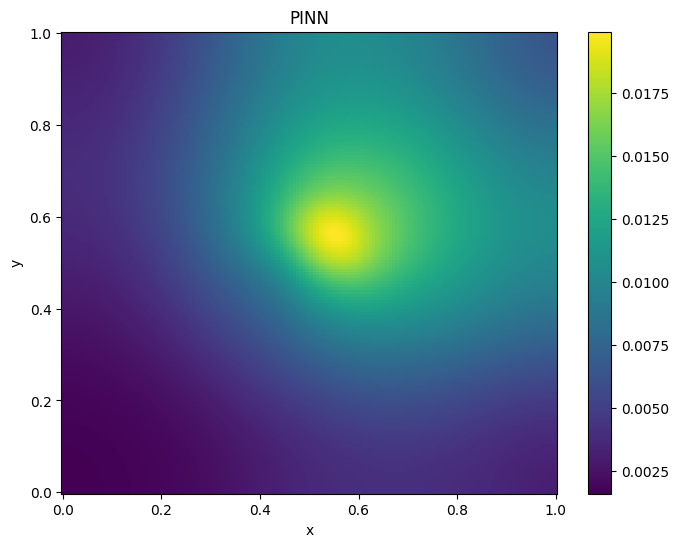

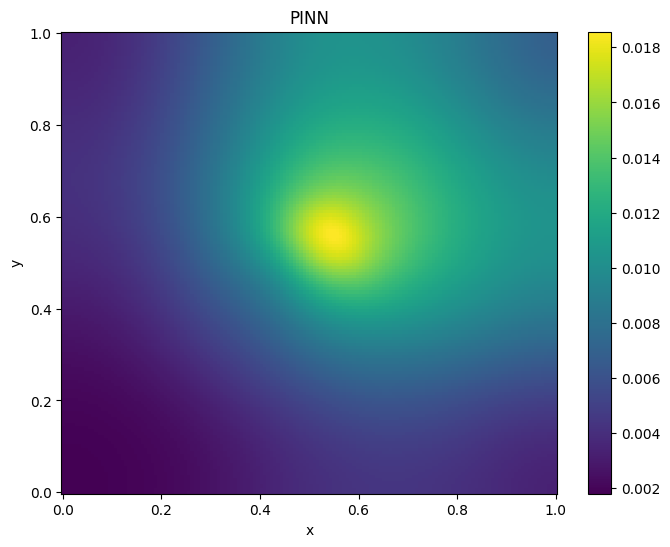

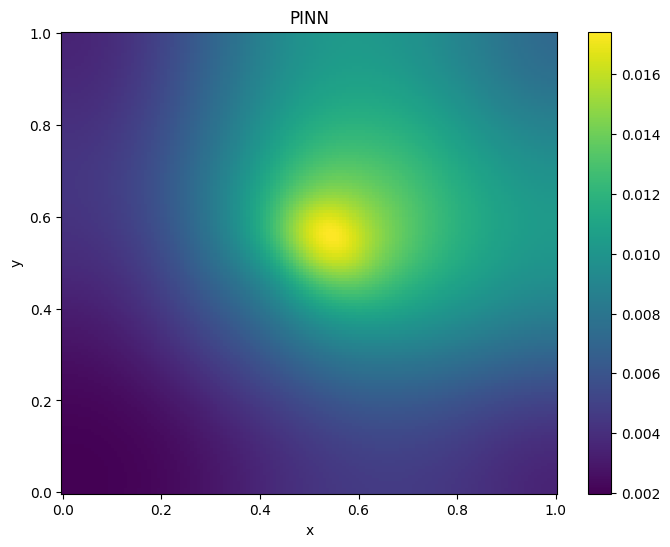

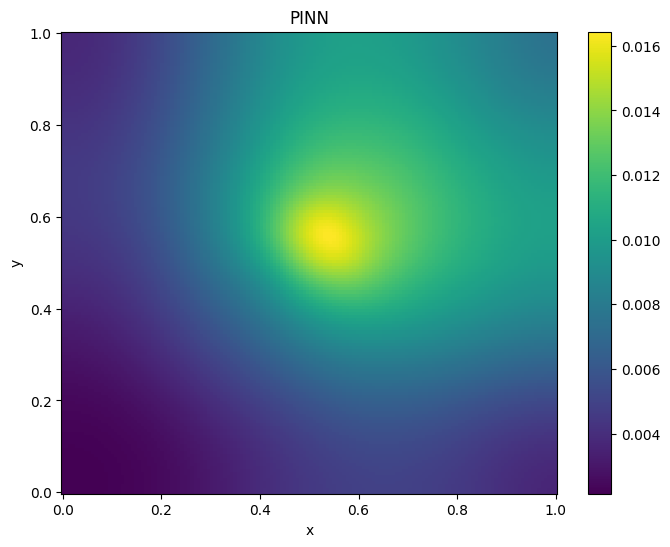

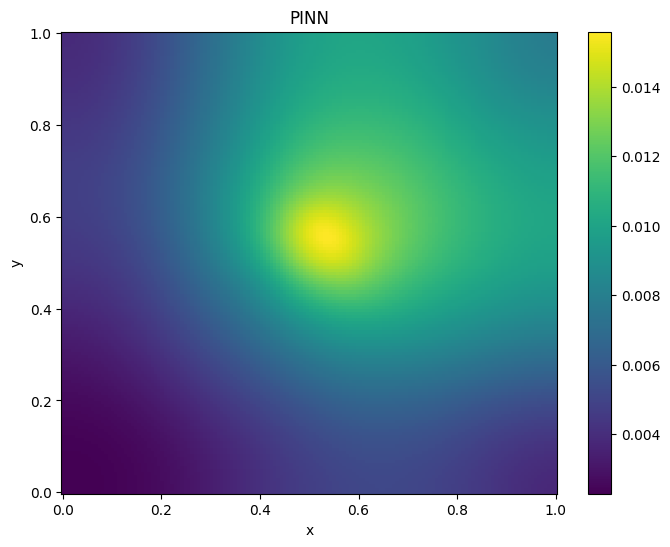

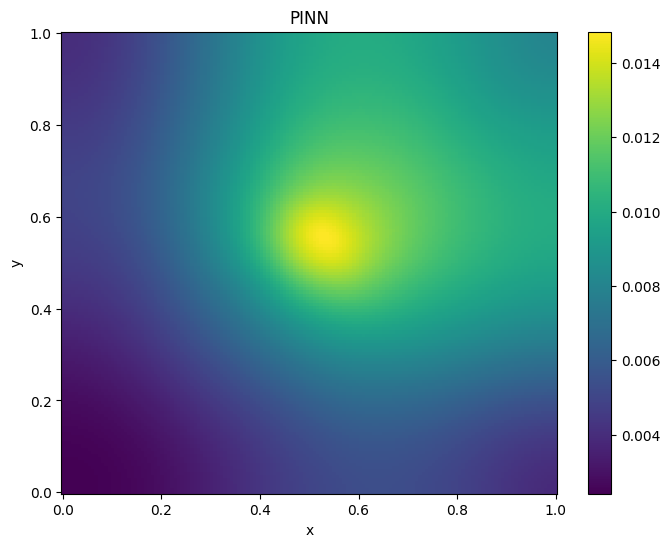

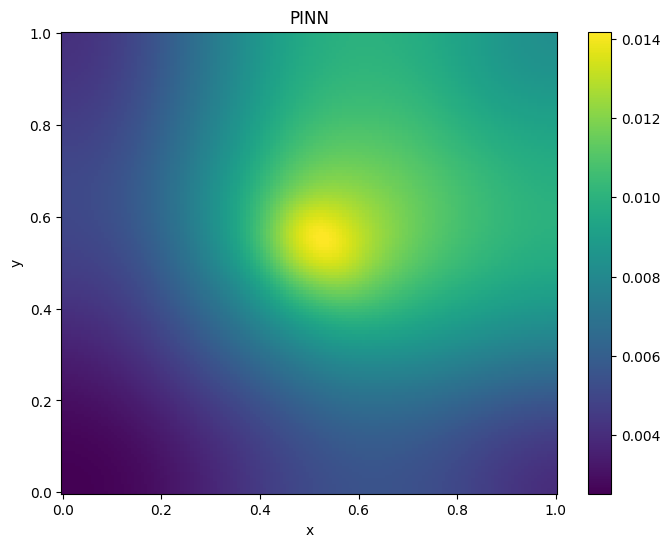

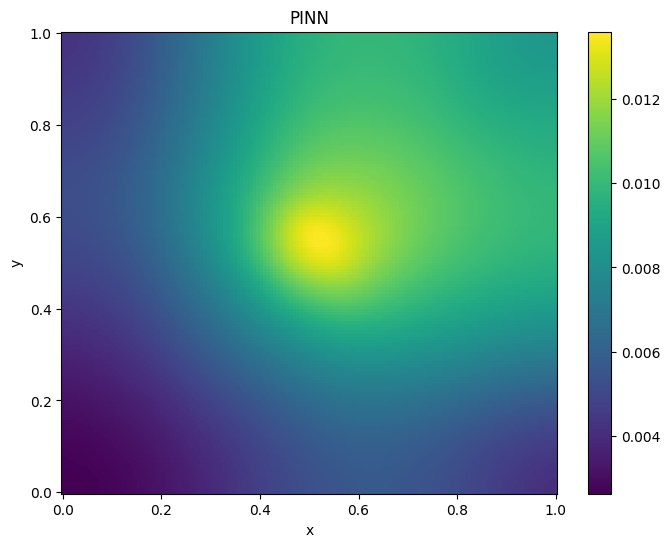

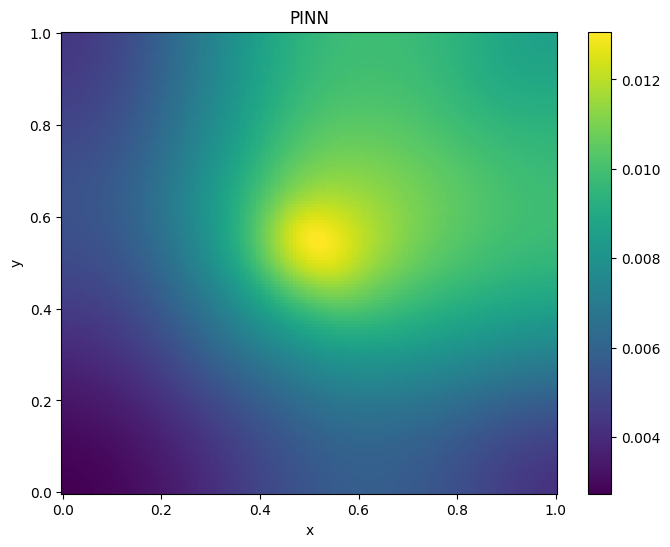

In [4]:
time_steps = 20
for i in range(time_steps):
    x, y, _ = get_initial_points(x_domain, y_domain, t_domain, N_POINTS_PLOT, requires_grad=False)
    t = torch.full_like(x, i*TOTAL_TIME/time_steps)
    z = pinn_trained(x, y, t)
    fig = plot_color(z, x, y, N_POINTS_PLOT, N_POINTS_PLOT, "PINN")
    plt.savefig(f'./tmp/img_{i}.png', transparent = True,  facecolor = 'white')